In [1]:
from qerr_utils import *

In [9]:
experiment_dir = 'data/start_2024-06-28T11:14:58.966542'
fpath = experiment_dir + '/' + 'data-type_MERGED.start_2024-06-28T11:14:58.966542'
qerr_df = load_data(fpath)

In [19]:
qerr_df

,pkt_unix_timestamp_TIM-TP,pkt_unix_timestamp_NAV-TIMEUTC,iTOW (ms),tAcc (ns),year,month,day,hour,min,sec,...,towMS (ms),towSubMS,qErr (ps),week (weeks),timeBase_flag,utc_flag,raim_flag,qErrInvalid_flag,timeRefGnss,utcStandard_TIM-TP
0,2024-06-28 11:14:59.941035,2024-06-28 11:14:59.949128,497718000,39,2024,6,28,18,15,0,...,497719000,0.0,-3293,2320,0,1,2,0,0,0
1,2024-06-28 11:15:00.956587,2024-06-28 11:15:00.963395,497719000,39,2024,6,28,18,15,1,...,497720000,0.0,-2960,2320,0,1,2,0,0,0
2,2024-06-28 11:15:01.943514,2024-06-28 11:15:01.954459,497720000,39,2024,6,28,18,15,2,...,497721000,0.0,-2479,2320,0,1,2,0,0,0
3,2024-06-28 11:15:02.957960,2024-06-28 11:15:02.962442,497721000,39,2024,6,28,18,15,3,...,497722000,0.0,-2441,2320,0,1,2,0,0,0
4,2024-06-28 11:15:03.941472,2024-06-28 11:15:03.953376,497722000,39,2024,6,28,18,15,4,...,497723000,0.0,-2192,2320,0,1,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2024-06-28 11:23:15.031742,2024-06-28 11:23:15.038337,498213000,40,2024,6,28,18,23,15,...,498214000,0.0,1412,2320,0,1,2,0,0,0
496,2024-06-28 11:23:16.038845,2024-06-28 11:23:16.043563,498214000,40,2024,6,28,18,23,16,...,498215000,0.0,2809,2320,0,1,2,0,0,0
497,2024-06-28 11:23:17.034070,2024-06-28 11:23:17.045812,498215000,40,2024,6,28,18,23,17,...,498216000,0.0,-2413,2320,0,1,2,0,0,0
498,2024-06-28 11:23:18.036109,2024-06-28 11:23:18.045154,498216000,40,2024,6,28,18,23,18,...,498217000,0.0,-51,2320,0,1,2,0,0,0


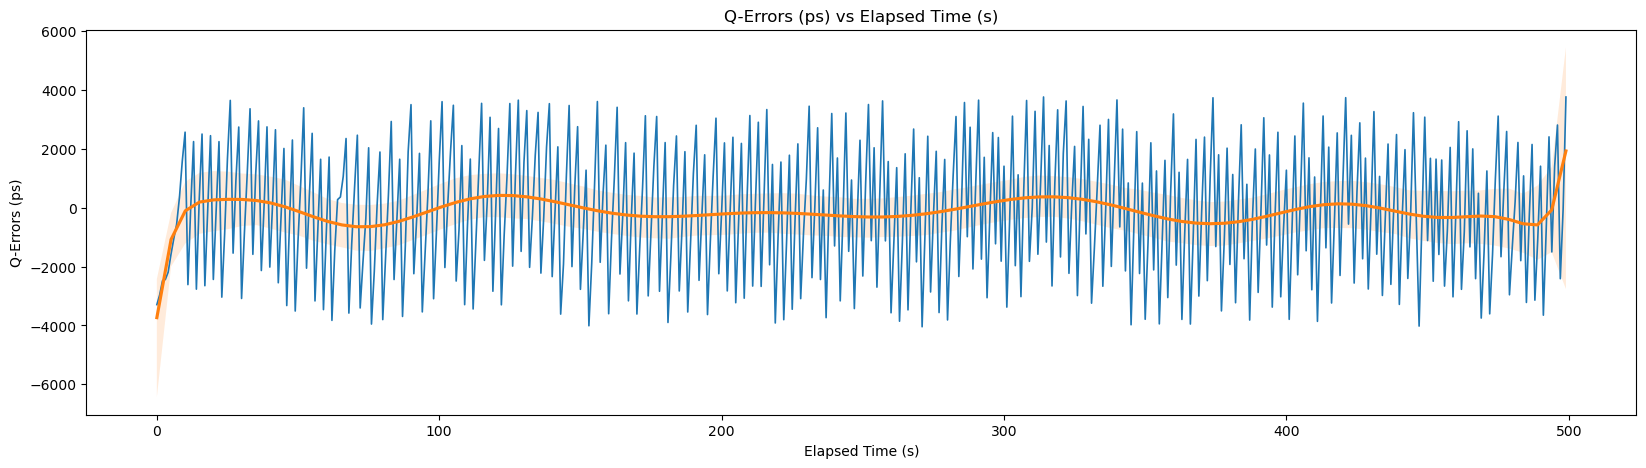

In [16]:
def qerr_vs_time(qerr_df):
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    df['seconds elapsed'] = (df['towMS (ms)'] - df['towMS (ms)'].min()) / 10**3
    sns.lineplot(df, x='seconds elapsed', y='qErr (ps)', linewidth=1.2, ax=ax)
    sns.regplot(df, x='seconds elapsed', y='qErr (ps)', scatter=False, ax=ax, order=17)
    
    ax.set_title('Q-Errors (ps) vs Elapsed Time (s)');
    ax.set_xlabel('Elapsed Time (s)')
    ax.set_ylabel('Q-Errors (ps)')
    
    # sns.histplot(tim_tp_df, x='qErr (ps)', stat='density', ax=axs[1])
    # axs[1].set_title('Distribution of Q-Errors (ps)')
    # axs[1].set_xlabel('Q-Errors (ps)');
qerr_vs_time(qerr_df)